In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

## EDA

In [2]:
fd = pd.read_csv("Chennai_1990_2022_Madras.csv")
fd

,time,tavg,tmin,tmax,prcp
0,01-01-1990,25.2,22.8,28.4,0.5
1,02-01-1990,24.9,21.7,29.1,0.0
2,03-01-1990,25.6,21.4,29.8,0.0
3,04-01-1990,25.7,NaN,28.7,0.0
4,05-01-1990,25.5,20.7,28.4,0.0
...,...,...,...,...,...
11889,21-07-2022,28.4,24.5,32.8,21.1
11890,22-07-2022,27.8,24.6,32.2,22.1
11891,23-07-2022,27.4,24.7,32.6,18.6
11892,24-07-2022,27.8,25.0,33.3,9.1


In [3]:
fd.isnull().sum()

time       0
tavg      27
tmin    3084
tmax    1019
prcp    4886
dtype: int64

In [4]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11894 entries, 0 to 11893
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    11894 non-null  object 
 1   tavg    11867 non-null  float64
 2   tmin    8810 non-null   float64
 3   tmax    10875 non-null  float64
 4   prcp    7008 non-null   float64
dtypes: float64(4), object(1)
memory usage: 464.7+ KB


In [5]:
fd.head()

,time,tavg,tmin,tmax,prcp
0,01-01-1990,25.2,22.8,28.4,0.5
1,02-01-1990,24.9,21.7,29.1,0.0
2,03-01-1990,25.6,21.4,29.8,0.0
3,04-01-1990,25.7,NaN,28.7,0.0
4,05-01-1990,25.5,20.7,28.4,0.0


In [6]:
dateparse = lambda x : pd.to_datetime(x, format='%d-%m-%Y',errors='coerce')
df = pd.read_csv('Chennai_1990_2022_Madras.csv',parse_dates = ['time'],index_col='time',date_parser=dateparse)

/tmp/ipykernel_7319/2987536676.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('Chennai_1990_2022_Madras.csv',parse_dates = ['time'],index_col='time',date_parser=dateparse)


In [7]:
df= df.drop(['tmin','tmax','prcp'],axis=1)

In [8]:
df.head()

,tavg
time,
1990-01-01,25.2
1990-01-02,24.9
1990-01-03,25.6
1990-01-04,25.7
1990-01-05,25.5


In [9]:
df.isna().sum()

tavg    27
dtype: int64

In [10]:
df['tavg'] = df['tavg'].interpolate(method='linear')

In [11]:
df['tavg'] = df['tavg'].round(1)

In [12]:
df.isna().sum()

tavg    0
dtype: int64

In [54]:
df.to_csv('chenai_cleaned1.csv',index=False)

<Axes: xlabel='time', ylabel='tavg'>

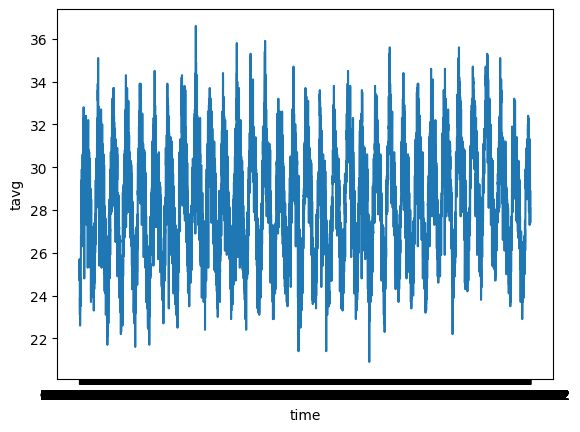

In [14]:
sns.lineplot(x='time',y='tavg',data=fd)

<Axes: >

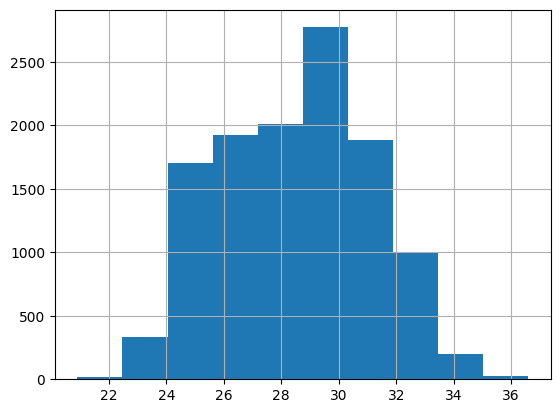

In [15]:
fd['tavg'].hist()

<Axes: ylabel='Density'>

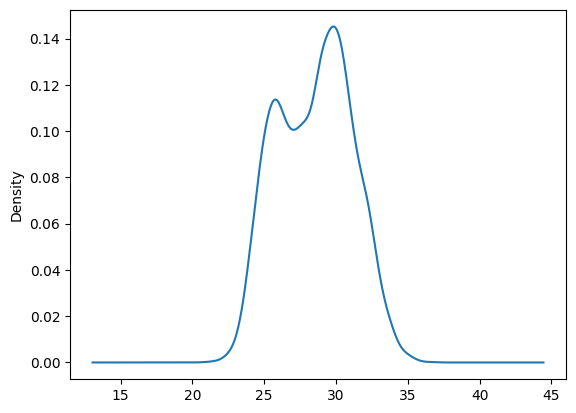

In [16]:
fd['tavg'].plot(kind='kde')

In [17]:
df['tavg'].describe()

count    11894.000000
mean        28.490600
std          2.606517
min         20.900000
25%         26.300000
50%         28.700000
75%         30.400000
max         36.600000
Name: tavg, dtype: float64

In [18]:
fd=df

In [19]:
def TestStationaryPlot(fd):
    rol_mean = fd.rolling(window = 20, center = False).mean()
    rol_std = fd.rolling(window = 20, center = False).std()
    
    plt.plot(fd, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

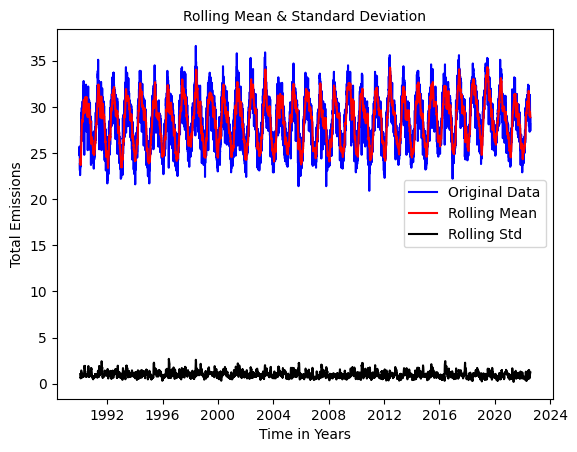

In [20]:
TestStationaryPlot(fd)

In [21]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(fd, cutoff = 0.01):
    fd_test = adfuller(fd, autolag = 'AIC')
    fd_test_output = pd.Series(fd_test[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    
    for key,value in fd_test[4].items():
        fd_test_output['Critical Value (%s)'%key] = value
    print(fd_test_output)
    
    if fd_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")
        

In [22]:
TestStationaryAdfuller(fd)

Test Statistic                -8.363175e+00
p-value                        2.787930e-13
Lags Used                      4.000000e+01
Number of Observations Used    1.185300e+04
Critical Value (1%)           -3.430902e+00
Critical Value (5%)           -2.861784e+00
Critical Value (10%)          -2.566900e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


# Trend & Seasonality Plot

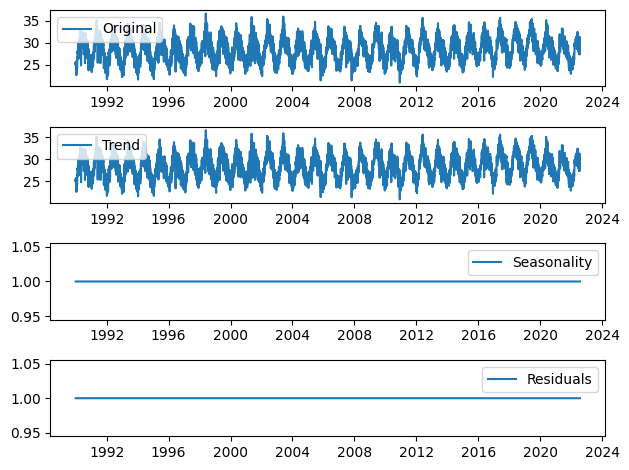

In [23]:
decomposition = seasonal_decompose(fd,period=1,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(fd, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# ACF & PACF Plots

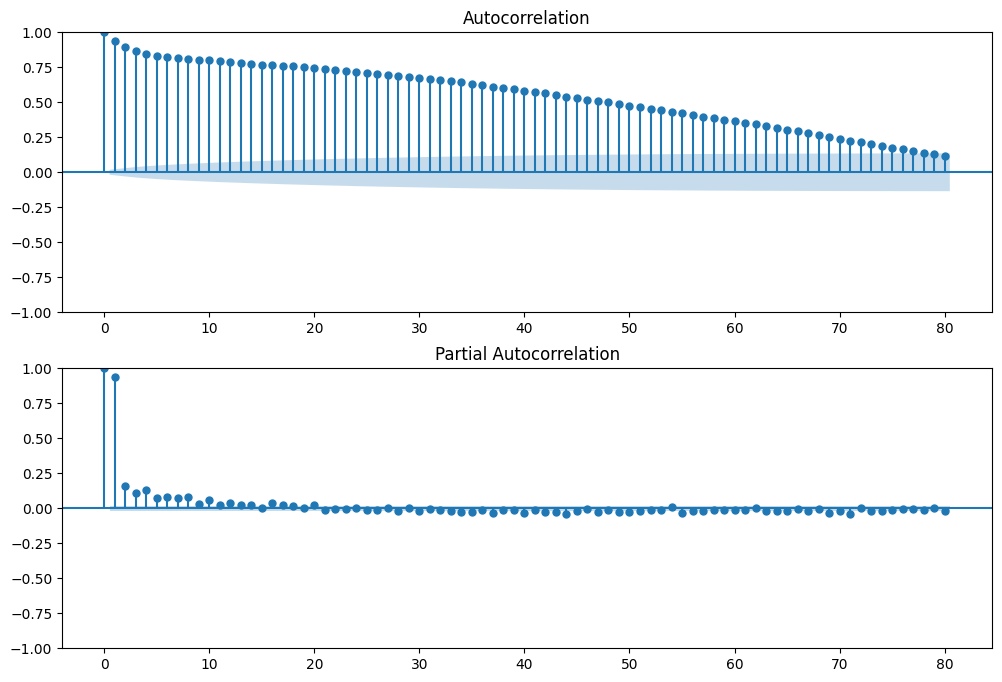

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(fd.dropna(inplace=False), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(fd.dropna(inplace=False), lags=80, ax=ax2)

# Data Partitioning

In [25]:
train = fd.iloc[:-30]
test = fd.iloc[-30:]

In [26]:
train

,tavg
time,
1990-01-01,25.2
1990-01-02,24.9
1990-01-03,25.6
1990-01-04,25.7
1990-01-05,25.5
...,...
2022-06-21,28.4
2022-06-22,28.8
2022-06-23,29.0


In [27]:
test

,tavg
time,
2022-06-26,29.9
2022-06-27,29.9
2022-06-28,29.6
2022-06-29,29.5
2022-06-30,30.0
2022-07-01,29.3
2022-07-02,29.4
2022-07-03,28.9
2022-07-04,29.9


# ARIMA MODEL

# ARIMA (6,0,2)

In [28]:
model_arima = ARIMA(train['tavg'],order = (6,0,2))
model_arima = model_arima.fit()
model_arima.summary()

/home/adarsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/adarsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/adarsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   tavg   No. Observations:                11864
Model:                 ARIMA(6, 0, 2)   Log Likelihood              -15445.814
Date:                Thu, 08 Aug 2024   AIC                          30911.629
Time:                        15:53:44   BIC                          30985.441
Sample:                    01-01-1990   HQIC                         30936.403
                         - 06-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.4773      0.384     74.099      0.000      27.724      29.231
ar.L1          0.6072      0.024     25.502      0.000       0.560       0.654
ar.L2          0.9393      0.031     29.995      0.000       0.878       1.001
ar.L3         -0.5803      0.020    -28.869      0.000      -0.620      -0.541
ar.L4          0.0080      0.012      0.641      0.522      -0.016       0.032
ar.L5          0.0197      0.011      1.793      0.073      -0.002       0.041
ar.L6         -0.0006      0.011     -0.055      0.956      -0.021       0.020
ma.L1          0.1081      0.023      4.775      0.000       0.064       0.152
ma.L2         -0.8119      0.022    -36.149      0.000      -0.856      -0.768
sigma2         0.7911      0.008    103.547      0.000       0.776       0.806
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2805.18
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2022-06-26    29.447787
2022-06-27    29.365105
2022-06-28    29.349545
2022-06-29    29.297793
2022-06-30    29.307138
2022-07-01    29.271309
2022-07-02    29.286639
2022-07-03    29.256198
2022-07-04    29.271969
2022-07-05    29.243985
2022-07-06    29.258882
2022-07-07    29.232570
2022-07-08    29.246343
2022-07-09    29.221451
2022-07-10    29.234101
2022-07-11    29.210508
2022-07-12    29.222093
2022-07-13    29.199713
2022-07-14    29.210300
2022-07-15    29.189059
2022-07-16    29.198713
2022-07-17    29.178544
2022-07-18    29.187328
2022-07-19    29.168166
2022-07-20    29.176139
2022-07-21    29.157926
2022-07-22    29.165142
2022-07-23    29.147822
2022-07-24    29.154333
2022-07-25    29.137853
Freq: D, Name: predicted_mean, dtype: float64


In [30]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 'rmse':rmse})

In [31]:
ns_arima_acc = forecast_accuracy(pred_arima.values, test.values)
ns_arima_acc

{'mape': 0.029992969942085803,
 'me': 0.14314842123320087,
 'mae': 0.8676014496663177,
 'rmse': 1.0536712178082437}

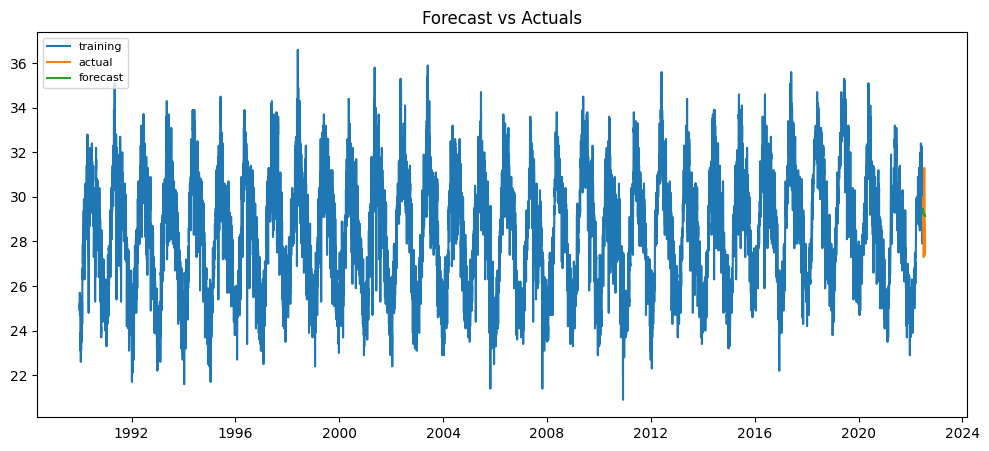

In [32]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# SMOOTHENING TECHNIQUE METHODS

In [33]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [34]:
SES = SimpleExpSmoothing(train['tavg']).fit(smoothing_level = 0.2)

/home/adarsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [35]:
pred_ses = SES.predict(start = len(train),end = len(train)+len(test)-1)

In [36]:
ns_ses_acc = forecast_accuracy(pred_ses,test.tavg)
ns_ses_acc

{'mape': 0.029759176509301998,
 'me': 0.0571640202981424,
 'mae': 0.8633333333333334,
 'rmse': 1.0431527813396493}

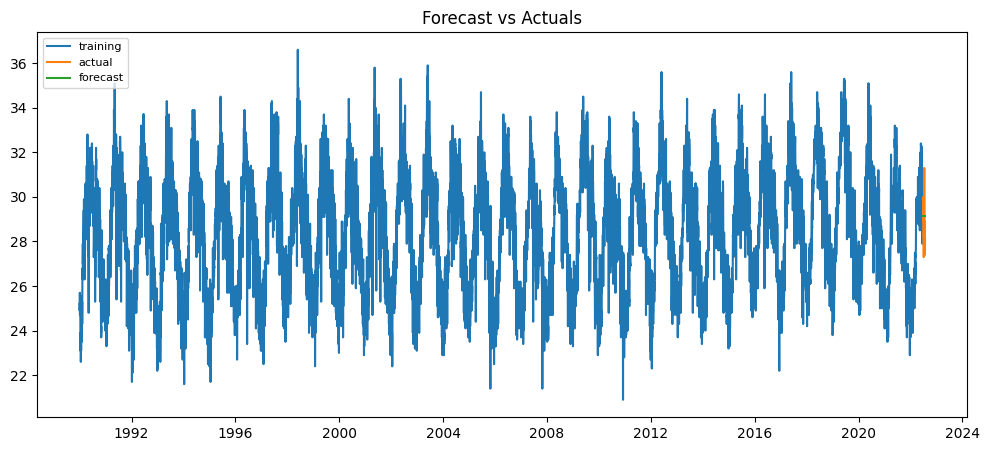

In [37]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# HOLT'S METHOD

In [38]:
HLT= Holt(train["tavg"]).fit(smoothing_level=0.8, smoothing_slope=0.2)

/home/adarsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_7319/1890604608.py:1: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  HLT= Holt(train["tavg"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [39]:
pred_holt = HLT.predict(start = len(train),end = len(train)+len(test)-1)

In [40]:
ns_hlt_acc = forecast_accuracy(pred_holt,test.tavg)
ns_hlt_acc

{'mape': 0.05801959398944476,
 'me': 1.5521760593342127,
 'mae': 1.6431038988287407,
 'rmse': 2.117751750266501}

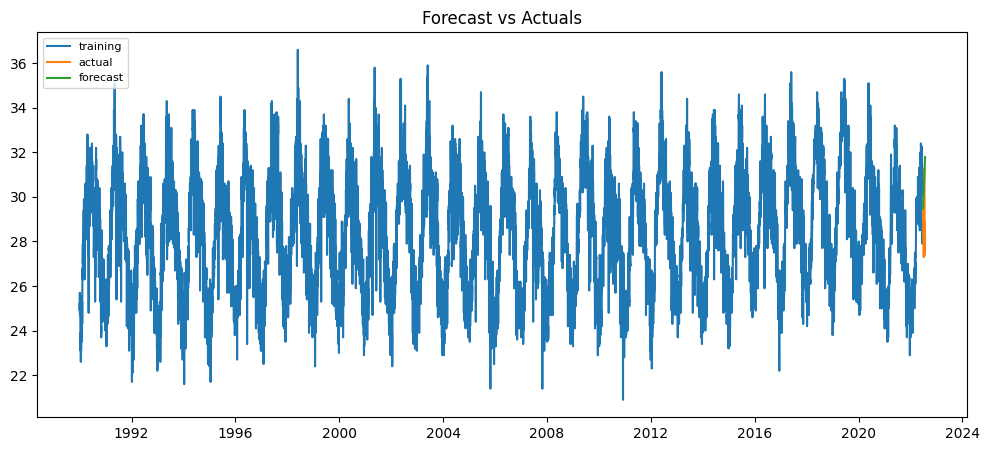

In [41]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# HOLT-WINTER METHOD

In [42]:
HLW = ExponentialSmoothing(train['tavg'],seasonal='add',trend='add',seasonal_periods=2).fit()

/home/adarsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [43]:
pred_hlw=HLW.predict(start = len(train),end = len(train)+len(test)-1)

In [44]:
ns_hlw_acc = forecast_accuracy(pred_hlw,test.tavg)
ns_hlw_acc

{'mape': 0.030783139657840217,
 'me': 0.3005991541999407,
 'mae': 0.8859820607641983,
 'rmse': 1.0832871477428605}

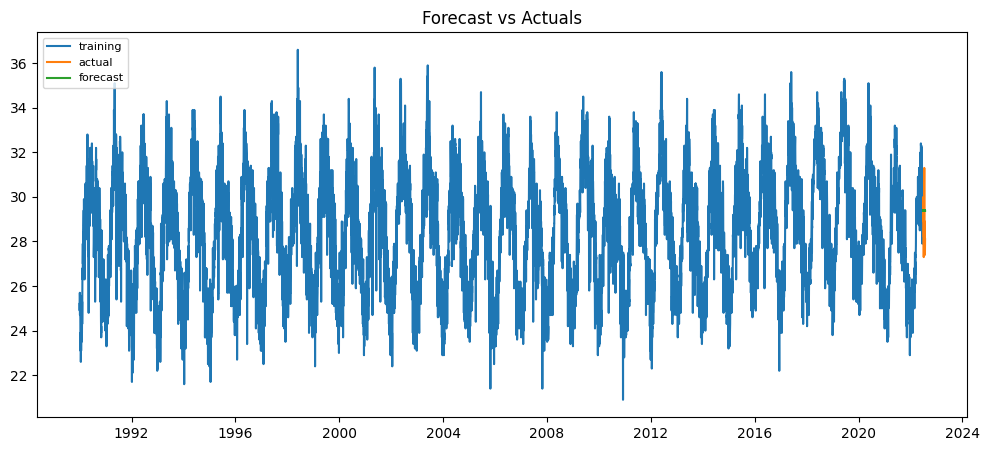

In [45]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hlw, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# MODELWISE ERRORS

In [46]:
data = {"MODEL":pd.Series(["ARIMA(7,1,2)","ARIMA(15,1,2)","Simple exponential smoothing","Holt Method","Holt-Winter Method"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],ns_arima_acc["rmse"],ns_ses_acc["rmse"],ns_hlt_acc["rmse"],ns_hlw_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],ns_arima_acc["mape"],ns_ses_acc["mape"],ns_hlt_acc["mape"],ns_hlw_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],ns_arima_acc["me"],ns_ses_acc["me"],ns_hlt_acc["me"],ns_hlw_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],ns_arima_acc["mae"],ns_ses_acc["mae"],ns_hlt_acc["mae"],ns_hlw_acc["mae"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values
2,Simple exponential smoothing,1.043153,0.029759,0.057164,0.863333
0,"ARIMA(7,1,2)",1.053671,0.029993,0.143148,0.867601
1,"ARIMA(15,1,2)",1.053671,0.029993,0.143148,0.867601
4,Holt-Winter Method,1.083287,0.030783,0.300599,0.885982
3,Holt Method,2.117752,0.058020,1.552176,1.643104


In [55]:
tata = {"MODEL":pd.Series(["ARIMA(6,0,2)","Simple exponential smoothing","Holt Method","Holt-Winter Method"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],ns_ses_acc["rmse"],ns_hlt_acc["rmse"],ns_hlw_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],ns_ses_acc["mape"],ns_hlt_acc["mape"],ns_hlw_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],ns_ses_acc["me"],ns_hlt_acc["me"],ns_hlw_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],ns_ses_acc["mae"],ns_hlt_acc["mae"],ns_hlw_acc["mae"]])}

table_mape=pd.DataFrame(tata)
table_mape.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values
1,Simple exponential smoothing,1.043153,0.029759,0.057164,0.863333
0,"ARIMA(6,0,2)",1.053671,0.029993,0.143148,0.867601
3,Holt-Winter Method,1.083287,0.030783,0.300599,0.885982
2,Holt Method,2.117752,0.058020,1.552176,1.643104


# Final model

In [56]:
model_arima = ARIMA(train['tavg'],order = (6,0,2))
model_arima = model_arima.fit()
model_arima.summary()

/home/adarsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/adarsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/adarsh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   tavg   No. Observations:                11864
Model:                 ARIMA(6, 0, 2)   Log Likelihood              -15445.814
Date:                Thu, 08 Aug 2024   AIC                          30911.629
Time:                        16:04:31   BIC                          30985.441
Sample:                    01-01-1990   HQIC                         30936.403
                         - 06-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.4773      0.384     74.099      0.000      27.724      29.231
ar.L1          0.6072      0.024     25.502      0.000       0.560       0.654
ar.L2          0.9393      0.031     29.995      0.000       0.878       1.001
ar.L3         -0.5803      0.020    -28.869      0.000      -0.620      -0.541
ar.L4          0.0080      0.012      0.641      0.522      -0.016       0.032
ar.L5          0.0197      0.011      1.793      0.073      -0.002       0.041
ar.L6         -0.0006      0.011     -0.055      0.956      -0.021       0.020
ma.L1          0.1081      0.023      4.775      0.000       0.064       0.152
ma.L2         -0.8119      0.022    -36.149      0.000      -0.856      -0.768
sigma2         0.7911      0.008    103.547      0.000       0.776       0.806
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2805.18
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
start=len(train)+774
end=start+10
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2024-08-08    28.479406
2024-08-09    28.479390
2024-08-10    28.479373
2024-08-11    28.479357
2024-08-12    28.479341
2024-08-13    28.479325
2024-08-14    28.479309
2024-08-15    28.479294
2024-08-16    28.479278
2024-08-17    28.479263
2024-08-18    28.479247
Freq: D, Name: predicted_mean, dtype: float64


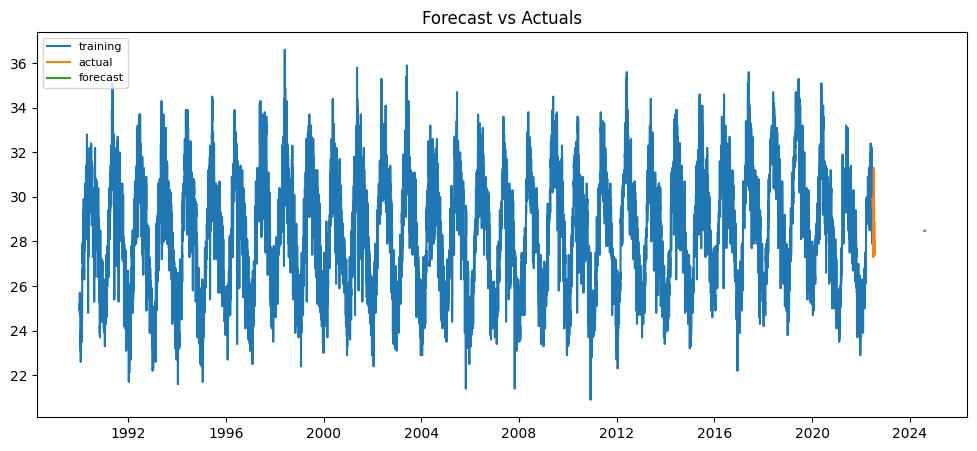

In [61]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [63]:
import pickle

with open('./chenai_model.pkl', 'wb') as file:
    pickle.dump(model_arima, file)